In [1]:
import os
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import pandas as pd
import datetime as datetime
from itertools import combinations
import numpy as np

In [ ]:
# Use your real keys here
API_KEY = '-'
SECRET_KEY = '-'

client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

### API Key Setup

Here, we define our **API key** and **secret key** from Alpaca to authenticate requests.

<div style="background-color:#fff3cd; padding:10px; border-radius:5px;">
⚠️ <b>Note:</b> Use your own API keys or your preferable API
</div>

In [3]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.to_list()

In [4]:
len(tickers)

503

In [ ]:
# This fixes symbols like BRK.B and BF.B for Alpaca (replace '.' with '-')
tickers = [ticker.replace('-', '.') for ticker in tickers]

**Process:**
1. `pd.read_html(url)` reads all HTML tables from the given URL.
2. `[0]` selects the first table on the page.
3. `.Symbol.to_list()` extracts the `Symbol` column into a Python list.

**Result:** A list of all current S&P 500 ticker symbols, e.g., `['AAPL', 'MSFT', 'GOOG', ...]`.

In [ ]:
# Initialize request dates
start_date = datetime.datetime(2022, 1, 1) #yy-mm-dd
end_date = datetime.datetime(2025, 8, 14) #yy-mm-dd

##### Here we fetch every ticker's price data using alpaca API, but set limit to 200 per request to prevent fetching limit.

In [ ]:
# Alpaca supports up to 200 tickers per call, so we batch them
from itertools import islice

def batched(iterable, n):
    """Split iterable into batches of size n"""
    it = iter(iterable)
    while batch := list(islice(it, n)):
        yield batch

# Store all dataframes
all_data = []

for batch in batched(tickers, 200):  # 200 = Alpaca's limit per request
    try:
        request_params = StockBarsRequest(
            symbol_or_symbols=batch,
            timeframe=TimeFrame.Day,
            start=start_date,
            end=end_date
        )
        bars = client.get_stock_bars(request_params)
        df = bars.df  # Contains multi-index: (symbol, timestamp)
        all_data.append(df)
        print(f"Downloaded batch: {batch[0]} to {batch[-1]} ({len(batch)} symbols)")
    except Exception as e:
        print(f"Failed to download batch: {batch}\nError: {e}")

# Combine all
df_all = pd.concat(all_data)
df_all = df_all.reset_index()  # Make symbol/timestamp regular columns
df_all

Downloaded batch: MMM to F (200 symbols)
Downloaded batch: FTNT to ROK (200 symbols)
Downloaded batch: ROL to ZTS (103 symbols)


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,ACGL,2022-01-03 05:00:00+00:00,44.50,44.680,44.0300,44.55,1742987.0,16088.0,44.419963
1,ACGL,2022-01-04 05:00:00+00:00,45.08,45.540,45.0100,45.13,1157304.0,12005.0,45.169897
2,ACGL,2022-01-05 05:00:00+00:00,46.57,46.570,44.4900,44.60,1242284.0,15256.0,44.965501
3,ACGL,2022-01-06 05:00:00+00:00,45.37,45.690,44.7600,44.86,1831125.0,19080.0,44.960674
4,ACGL,2022-01-07 05:00:00+00:00,45.12,45.270,44.7600,45.07,2132089.0,19795.0,45.046867
...,...,...,...,...,...,...,...,...,...
452590,ZTS,2025-08-07 04:00:00+00:00,147.50,149.000,146.9000,148.24,3786743.0,46554.0,147.909404
452591,ZTS,2025-08-08 04:00:00+00:00,148.35,148.995,146.2700,147.35,2062131.0,36666.0,147.445381
452592,ZTS,2025-08-11 04:00:00+00:00,147.67,149.810,147.3500,149.02,3065321.0,38788.0,148.775057
452593,ZTS,2025-08-12 04:00:00+00:00,148.91,149.880,148.3136,149.77,2578472.0,36571.0,149.391346


In [ ]:
# Ensure timestamp is in datetime format
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])

# Pivot: rows = hourly timestamp, columns = symbols, values = close price
df = df_all.pivot(index='timestamp', columns='symbol', values='close')

# Sort rows by timestamp
df = df.sort_index()

df.head()

symbol,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-03 05:00:00+00:00,156.48,182.01,135.42,172.68,139.04,44.55,407.21,564.37,177.15,67.89,...,40.57,87.77,67.94,63.54,116.89,164.03,136.53,129.13,583.90,234.03
2022-01-04 05:00:00+00:00,151.19,179.70,135.16,170.80,135.77,45.13,404.30,554.00,175.55,69.15,...,41.09,87.49,68.37,65.93,118.13,156.33,137.26,130.44,587.60,225.12
2022-01-05 05:00:00+00:00,148.60,174.92,135.87,162.25,135.16,44.60,397.18,514.43,172.84,68.61,...,40.07,84.25,69.04,66.75,116.52,143.49,135.52,130.01,558.18,216.56
2022-01-06 05:00:00+00:00,149.12,172.00,135.23,159.75,135.14,44.86,378.00,514.12,173.39,69.22,...,40.39,84.64,68.50,68.32,116.36,144.66,136.92,128.93,555.16,217.42
2022-01-07 05:00:00+00:00,145.15,172.17,134.88,166.05,135.56,45.07,370.75,510.70,168.84,69.81,...,40.34,84.55,69.10,68.88,115.43,141.54,135.35,128.15,530.86,211.09


#### Check missing values in dataframe

In [11]:
missing = df.isna().mean().sort_values(ascending=False)
print(missing.head(10))  # Top tickers with most missing data

symbol
PSKY    0.994481
GEV     0.621413
SOLV    0.620309
VLTO    0.483444
KVUE    0.369757
GEHC    0.264901
WBD     0.069536
CEG     0.023179
AAPL    0.000000
ABBV    0.000000
dtype: float64


- PSKY is missing 99% of its data → essentially unusable for most modeling/analysis.
- GEV and SOLV have > 60% missing → borderline unusable unless you have a very specific reason to keep them.
- Companies like AAPL or ABBV have complete data.

possible causing problem of NA values:
- KVUE (Kenvue) joined the S&P 500 in 2023 after spinning off from Johnson & Johnson, it has no data before its listing date.
- KVUE (spin-off from J&J, May 2023 IPO), GEHC (spin-off from GE, Jan 2023 IPO), SOLV and GEV might be similar cases (chemical and energy companies spun off recently).

In [12]:
# Drop tickers with > 80% missing data
threshold = 0.8
drop_tickers = missing[missing > threshold].index
df = df.drop(columns=drop_tickers)

# Forward fill small gaps for remaining tickers
df = df.ffill()

In [13]:
from itertools import combinations

pairs = list(combinations(df.columns, 2))

if pairs:
    combined_df = pd.DataFrame(pairs, columns=['asset_1', 'asset_2'])
else:
    print("Not enough assets with complete data to form pairs.")
    combined_df = pd.DataFrame(columns=['asset_1', 'asset_2'])


In [14]:
# Calculate the log returns of an asset and drop the first value.
log_returns = np.log(df / df.shift(1)).dropna()

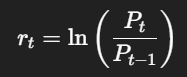

- 𝑟𝑡 = log return at time 𝑡 
- 𝑃𝑡 = price (or adjusted close) at time 𝑡
- 𝑃𝑡 − 1 = price at previous time step
- ln = natural logarithm

Why we use log returns instead of simple returns?

Additivity over time, if we sum log returns over multiple periods, you get the total log return, unlike simple returns, which need compounding. This also outputs better statistical properties, closer to normal distribution for many assets. It also handles large changes symmetrically: A +50% move followed by a −50% move is not zero, and log returns capture that cleanly.

#### Combine every possible pair into a dataframe

In [15]:
combined_df

,asset_1,asset_2
0,A,AAPL
1,A,ABBV
2,A,ABNB
3,A,ABT
4,A,ACGL
...,...,...
125746,YUM,ZBRA
125747,YUM,ZTS
125748,ZBH,ZBRA
125749,ZBH,ZTS


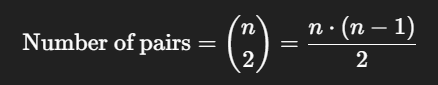

502 x 501 / 2 = 251502/2 = 125751

In [ ]:
# Calculate correlation using log returns
def calc_corr(row):
    asset1 = row['asset_1']
    asset2 = row['asset_2']
    
    series1 = log_returns[asset1]
    series2 = log_returns[asset2]
    
    # Drop any rows with NaNs in either series
    valid_idx = series1.notna() & series2.notna()
    
    if valid_idx.sum() < 10:  # Avoid short series
        return np.nan
    
    return np.corrcoef(series1[valid_idx], series2[valid_idx])[0, 1]

In [ ]:
# Apply correlation calculation
combined_df['Correlation'] = combined_df.apply(calc_corr, axis=1)

# Filter log reutrn high correlations above 0.9
correlation_df = combined_df[combined_df['Correlation'] > 0.9].dropna()

In [18]:
correlation_df

,asset_1,asset_2,Correlation
11989,AMAT,KLAC,0.932090
20302,AVB,EQR,0.932850
58363,DHI,LEN,0.905825
58456,DHI,PHM,0.914326
60919,DOW,LYB,0.900129
69089,EQR,UDR,0.904291
77235,FOX,FOXA,0.987086
82680,GOOG,GOOGL,0.997638
100192,LEN,PHM,0.918331
105928,MET,PRU,0.904927


Find Cointegration not just correlation by using Augemented Dickey-Fuller Test

Augemented Dickey-Fuller Test: Unit Route test that checks a ones statistical properties (mean and variance), do not change overtime. In this SPY case, if the spread between two stocks is stationary, it indicates that the relationship is stable and will not drift.

If ADF test rejects the null hypothesis (p-value larger than a certain thereshold), spread is non-stationary meaning two stocks might drift apart overtime.

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def engle_granger_test(asset1, asset2):
    # Get price series
    y = df[asset1]
    x = df[asset2]
    
    # Remove NaNs
    df_adf = pd.concat([x, y], axis=1).dropna()
    x = df_adf[asset2]
    y = df_adf[asset1]

    # Regress y on x (y = alpha + beta*x)
    x_const = sm.add_constant(x)
    model = sm.OLS(y, x_const).fit()
    alpha, beta = model.params

    # Residuals (spread)
    residuals = y - model.predict(x_const)

    # ADF test on residuals
    adf_result = adfuller(residuals)

    return pd.Series({
        'ADF_stat': adf_result[0],
        'p_value': adf_result[1],
        'beta': beta,
        'alpha': alpha
    })

In [20]:
# Apply to your filtered pairs (from log-return correlation)
cointegration_results = correlation_df.apply(
    lambda row: engle_granger_test(row['asset_1'], row['asset_2']), axis=1
)

In [ ]:
# Merge results back to combined_df
cointegrated_df = correlation_df.join(cointegration_results)

# Keep only cointegrated pairs (p-value < 0.1), we can use 0.05 if needed.
cointegrated_df = cointegrated_df[cointegrated_df['p_value'] < 0.1].reset_index(drop=True)

cointegrated_df.sort_values(by='ADF_stat')

,asset_1,asset_2,Correlation,ADF_stat,p_value,beta,alpha
2,GOOG,GOOGL,0.997638,-5.490989,0.000002,1.001992,0.894906
1,FOX,FOXA,0.987086,-2.905987,0.044656,0.927541,-0.002664
0,DHI,PHM,0.914326,-2.707873,0.072686,1.031804,33.275786


## Augmented Dickey–Fuller (ADF) Test

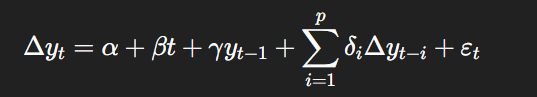

where:
- $y_t$ = time series being tested (the spread residuals)
<br>
- $\Delta y_t = y_t - y_{t-1}$ (first difference)
<br>
- $\gamma$ = the key coefficient $\rightarrow$ if $\gamma=0$, there's a unit root (non-stationary)
<br>
- $p$ = number of lags to remove autocorrelation

The Augmented Dickey–Fuller (ADF) statistic of −2.707873 is the t-statistic for testing whether the spread between the two assets has a unit root (γ = 0). More negative values indicate stronger evidence against the null hypothesis $𝐻_0$ of a unit root, meaning the spread is more likely stationary. In our case, the 5% critical value is around −2.86 (depending on sample size), so −2.7078 is less negative than that threshold, meaning we cannot reject $𝐻_0$ at the 5% significance level but can reject it at the 10% level (consistent with the p-value ≈ 0.0727). This matters for pairs trading because even if two stocks are highly correlated, correlation alone can be spurious. The ADF test on the residuals from the regression $y_t ​= α + β x t ​+ ε t$ checks if the spread is stationary and mean-reverting. If it is stationary, deviations from the mean are likely temporary, creating potential opportunities for profitable mean-reversion trades.

### Beta (𝛽)

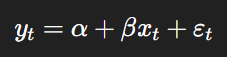

Here:
- 𝑦𝑡 = PHM price
- 𝑥𝑡​ = DHI price
- 𝛽 = hedge ratio: the slope of the relationship.

Interpretation:
- For every $1 change in DHI, PHM tends to change by about $1.0318 in the same direction.
- This is the scaling factor we use when building the spread:

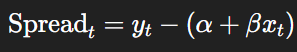

Without β, we’d just subtract the prices, which may not account for magnitude differences.

In [22]:
spread = df['PHM'] - (33.275786 + 1.031804 * df['DHI'])

#### Why do we use a 60-day Rolling Mean and Rolling Standard Deviation ?

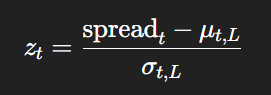

𝜇𝑡,𝐿 = mean of the last 𝐿 periods (lookback = 60)
σ𝑡,𝐿 = std. deviation of the last 𝐿 periods
𝐿 = rolling window length (60 days)

Reason for rolling:
- The spread’s distribution can drift over time (mean shifts, volatility changes), so we update with rolling mean.
- Using a fixed full-sample mean/std could miss these changes and give false signals.
- Rolling statistics adapt to the recent regime and make Z-scores comparable over time.

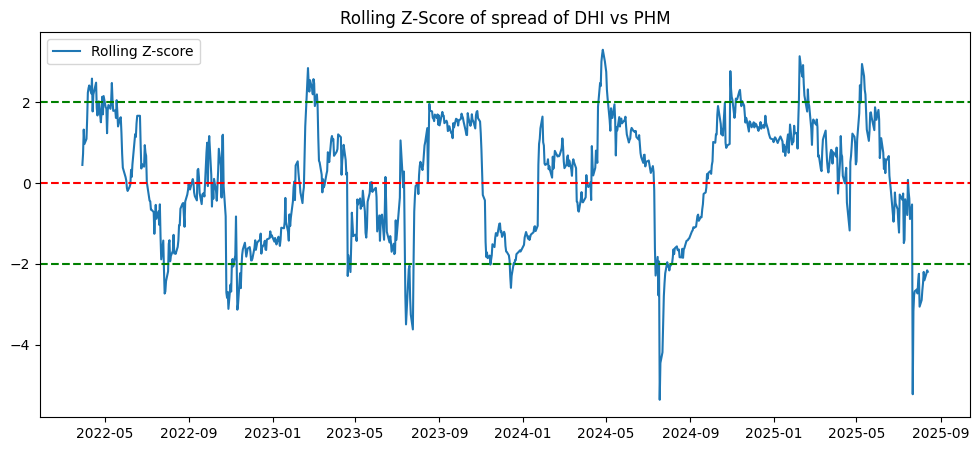

In [ ]:
lookback = 60  # 60 hours/days

# Rolling z-score
rolling_mean = spread.rolling(lookback).mean()
rolling_std = spread.rolling(lookback).std()
z_score = (spread - rolling_mean) / rolling_std

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(z_score, label='Rolling Z-score')
plt.axhline(0, color='red', linestyle='--')
plt.axhline(2, color='green', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.title('Rolling Z-Score of spread of DHI vs PHM')
plt.legend()
plt.show()

- Blue line = rolling Z-score of the spread (how many std devs it is from recent mean)

- Red dashed line (0) = spread at its mean

- Green dashed lines (±2) = ±2 standard deviation thresholds (common entry signals)

#### Trade strategy in mean reversion
For a cointegrated pair:
- Go SHORT the spread (short 𝑦, long 𝑥) when:
    - Z-score > +2
    - Spread is unusually high → expect it to fall back toward mean.

- Go LONG the spread (long 𝑦, short 𝑥) when:
    - Z-score < -2
    - Spread is unusually low → expect it to rise back toward mean.

- Exit when Z-score crosses back near 0 (mean reversion achieved).

#### Interpretation:

Spread = PHM - (alpha + beta * DHI)

- If Z-score > 2 → PHM is rich relative to DHI → short PHM, long DHI.

- If Z-score < −2 → PHM is cheap relative to DHI → long PHM, short DHI.